Modify this notebook! The other one is functional. Try changing how the network outputs the paramters. Also try squashing the outputs onto one axis and see if that changes training

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
from tensorflow.keras.layers import Dense, GRU, Input, Bidirectional
import pickle
import matplotlib.pyplot as plt

In [10]:
with open("../novelTrackReco/novelTrackRecoCylindricalData.pkl", "rb") as fp:
    X = pickle.load(fp)
    Y = pickle.load(fp)

In [14]:
max(Y[:,:,2].flatten())

1144.9156494140625

In [7]:
with open("../novelTrackReco/novelTrackRecoCylindricalData.pkl", "rb") as fp:
    X = pickle.load(fp)
    Y = pickle.load(fp)

X = X.astype(np.float32)
Y = Y.astype(np.float32)
#normalize data
# xNorm = 1068
# yNorm = 1068
# zNorm = 3025.5

phiNorm = np.pi
rhoNorm = 1030
zNorm = 1145
rNorm = np.sqrt(rhoNorm**2 + zNorm**2)


X[:,:,0] = X[:,:,0]/rhoNorm
X[:,:,1] = X[:,:,1]/phiNorm
X[:,:,2] = X[:,:,2]/zNorm

Y[:,:,0] = Y[:,:,0]/rNorm
Y[:,:,1] = Y[:,:,1]/phiNorm
Y[:,:,2] = Y[:,:,2]/zNorm

#predict only phi/z
Y = Y[:,:,1:]

train_frac = int(len(X)*.8)
train_input = X[0:train_frac]
train_target = Y[0:train_frac]
test_input = X[train_frac:]
test_target = Y[train_frac:]

batch_size = 512
train_dataset = tf.data.Dataset.from_tensor_slices((train_input, train_target))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((test_input, test_target))
test_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

In [9]:
max(X[:,:,0].flatten())

0.8305807

In [3]:
class GaussianRNN(tf.keras.Model):
    def __init__(self, n_inputHits, n_inputFeatures=3, n_outputFeatures=5):
        #output feature_1, feature_2, sigma_1, sigma_2, corr_12
        super().__init__()
        self.n_inputHits = n_inputHits
        
        self.inputs = Input(shape=(n_inputHits,n_inputFeatures))
        self.gru1 = GRU(32, return_sequences=True)
        self.gru2 = GRU(32, return_sequences=True)
        self.out = Dense(5)
        
    def call(self, inputs):
        shape = tf.shape(inputs)
        x = self.gru1(inputs)
        x = self.gru2(x)
        outputs = self.out(x)
        outputs = tf.reshape(outputs, (-1, 5))
        mean = outputs[:,:2]
        var = tf.math.exp(outputs[:,2:4])
        var = tf.math.sqrt(var)
        correlations = tf.math.tanh(outputs[:,4:])
        correlations = tf.reshape(correlations, (shape[0]*shape[1],1,1))
        identity = tf.eye(2, batch_shape=[shape[0]*shape[1]],dtype=tf.float32)
        
        corr_matrix = tf.cast(tf.math.equal(identity,0), tf.float32) * correlations
        corr_matrix = identity+corr_matrix
        
        covs = tf.matmul(var[:, :,None], var[:, None, :])
        covs = covs * corr_matrix
        #outputs = self.concat([mean, covs]) 
        mean = tf.reshape(mean, (shape[0], shape[1], 2))
        covs = tf.reshape(covs, (shape[0], shape[1],2,2))
        return mean, covs
    
    def train_step(self, inputs):
        inputs, targets = inputs
        with tf.GradientTape() as tape:
            outputs = self(inputs)
            print(outputs[0].shape, outputs[1].shape)
            loss = self.compiled_loss(outputs, targets)

        #should this be indented?
        grads = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {m.name: m.result() for m in self.metrics}
    
def gaus_llh_loss(outputs, targets):
    """Custom gaussian log-likelihood loss function"""
    means = outputs[0]
    covs = outputs[1]
    #print(len(outputs))
    #print("mean shape: ", means.shape, " covs shape: ", covs.shape)
    m_shape = tf.shape(means)
    t_shape = tf.shape(targets)
    c_shape = tf.shape(covs)
    means = tf.reshape(means, (m_shape[0]*m_shape[1], m_shape[2]))
    targets = tf.reshape(targets,(t_shape[0]*t_shape[1], t_shape[2]))
    covs = tf.reshape(covs, (c_shape[0]*c_shape[1], c_shape[2], c_shape[3]))
    # Calculate the inverses of the covariance matrices
    inv_covs = tf.linalg.inv(covs)
    # Calculate the residual error
    res = targets - means
    #res = tf.reshape(res, (shape[0], shape[1],2,1))
    # Calculate the residual error term
    res_right = tf.matmul(inv_covs, res[:,:,None])
    res_term = tf.matmul(res[:,None,:], res_right)
    diag_chols = tf.linalg.diag_part(tf.linalg.cholesky(covs))
    log_det = tf.reduce_sum(diag_chols, axis=1)
    log_det = tf.math.log(log_det)*2
    gllh_loss = tf.reduce_sum(res_term[:,:,0] + log_det, axis=-1)
    
    return tf.reduce_mean(gllh_loss)

In [5]:
# from tensorflow.python.framework.ops import disable_eager_execution 
# disable_eager_execution() 
# tf.executing_eagerly()

In [9]:
#custom training loop
#model = GaussianRNN(train_input.shape[1])
loss_fn = gaus_llh_loss
optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3)
best_loss = 0
epochs = 1
for epoch in range(epochs):
    for step, (x_batch_train ,y_batch_train) in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            pred = model(x_batch_train)
            loss_value = loss_fn(pred, y_batch_train)
            
        grads = tape.gradient(loss_value, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        # Save best model only
#         if loss_value < best_loss:
#             model.save("trained_models/biGausRNN")
#             best_loss = loss_value
        
    print("Training loss (for one batch) at epoch %d: %.4f" % (epoch, float(loss_value)))
        

Training loss (for one batch) at epoch 0: -1172.4487


In [10]:
model.save("trained_models/GausRNNFullDetector")

2022-05-22 20:21:08.139860: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: trained_models/GausRNNFullDetector/assets


INFO:tensorflow:Assets written to: trained_models/GausRNNFullDetector/assets


In [4]:
model = tf.keras.models.load_model('trained_models/GausRNN')

In [18]:
t = test_input[0,0:3,:].reshape(1,-1,3)
z = np.zeros((1,6,3))
t = np.append(t, z, axis=1)

In [19]:
t

array([[[ 0.024094  ,  0.30036235, -0.02130648],
        [ 0.04846006,  0.30092046, -0.04285361],
        [ 0.08094172,  0.30166441, -0.07157765],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ]]])

In [20]:
predictions = model.predict(t)
covs = predictions[1]
predictions=predictions[0]

2022-06-07 17:28:29.963567: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8302
2022-06-07 17:28:30.123894: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [21]:
predictions

array([[[ 0.3004917 , -0.02526765],
        [ 0.3012348 , -0.06943994],
        [ 0.30206954, -0.10823067],
        [-0.2419339 ,  0.00856833],
        [-0.07868862,  0.01734583],
        [-0.00948925,  0.0450827 ],
        [-0.01617593,  0.01816812],
        [-0.01697122,  0.00755559],
        [-0.01435129,  0.00647882]]], dtype=float32)

In [23]:
test_target[0]

array([[ 0.30092046, -0.04285361],
       [ 0.3016644 , -0.07157765],
       [ 0.30257255, -0.10663965],
       [ 0.30402988, -0.1629072 ],
       [ 0.30560485, -0.22371623],
       [ 0.30791   , -0.3127155 ],
       [ 0.3104857 , -0.4121619 ],
       [ 0.3131349 , -0.5144463 ],
       [ 0.31622085, -0.6335934 ]], dtype=float32)

In [21]:
from copy import deepcopy
predictions[:,:,0] *= np.pi
predictions[:,:,1] *= zNorm

targets = deepcopy(test_target)
targets[:,:,0] = test_target[:,:,0] * np.pi
targets[:,:,1] = test_target[:,:,1] * zNorm

phiErr = np.sqrt(covs[:,:,0,0]) 
zErr = np.sqrt(covs[:,:,1,1]) *zNorm

In [22]:
phiErr

array([[0.00696638, 0.00419331, 0.00469897, ..., 0.00614945, 0.00644464,
        0.00678206],
       [0.02651724, 0.0071569 , 0.00629259, ..., 0.00741341, 0.0075774 ,
        0.00773971],
       [0.00679073, 0.00414323, 0.00464997, ..., 0.00605453, 0.0063101 ,
        0.00658002],
       ...,
       [0.01373172, 0.00516656, 0.00528802, ..., 0.0065833 , 0.00683019,
        0.00714186],
       [0.00710664, 0.00412028, 0.00456826, ..., 0.00578164, 0.00596997,
        0.00619992],
       [0.03415146, 0.0086225 , 0.00688291, ..., 0.00851285, 0.00905688,
        0.00976465]], dtype=float32)

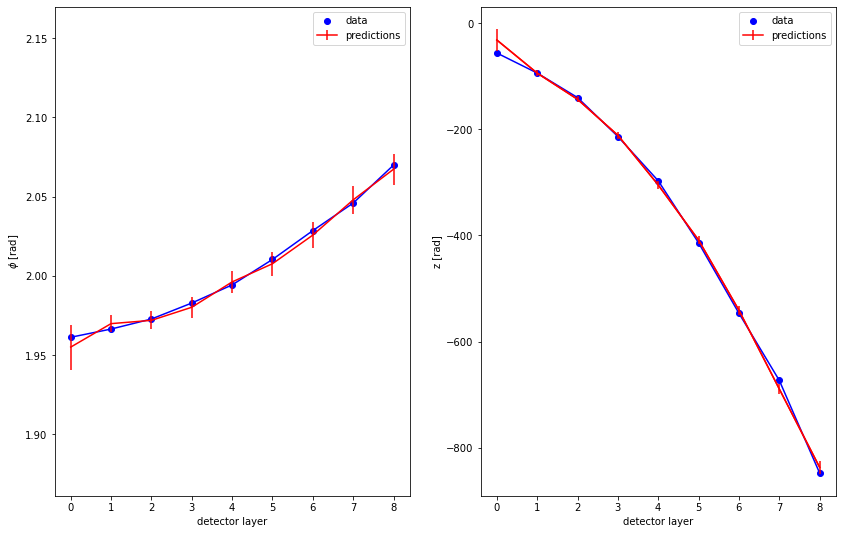

In [26]:
hitNum=4

fig, axs = plt.subplots(1,2,figsize=(14,9))
axs[0].scatter(np.arange(targets.shape[1]), targets[hitNum,:,0], label='data', color='blue')
axs[0].plot(np.arange(targets.shape[1]), targets[hitNum,:,0], color='blue')
axs[0].errorbar(np.arange(predictions.shape[1]), predictions[hitNum,:,0], 
              yerr=phiErr[hitNum], label='predictions', color='red')
axs[0].set_xlabel('detector layer')
axs[0].set_ylabel(r'$\phi$ [rad]')
axs[0].set_ylim([targets[hitNum,0,0]-.1, targets[hitNum,-1,0]+.1])
axs[0].legend()

axs[1].scatter(np.arange(targets.shape[1]), targets[hitNum,:,1], label='data', color='blue')
axs[1].plot(np.arange(targets.shape[1]), targets[hitNum,:,1], color='blue')


#plt.scatter(np.arange(predictions.shape[1]), predictions[hitNum,:,1].detach().cpu(), label='filter', color='red')
axs[1].errorbar(np.arange(predictions.shape[1]), predictions[hitNum,:,1], 
          yerr=zErr[hitNum], label='predictions', color='red')
axs[1].plot(np.arange(predictions.shape[1]), predictions[hitNum,:,1], color='red')

axs[1].set_xlabel('detector layer')
axs[1].set_ylabel('z [rad]')
axs[1].legend()

In [12]:
def residuals(data, predictions):
    res = data-predictions
    res = res.flatten()
    return res

Text(0.5, 0, '$(\\phi_{true} - \\phi_{pred})$')

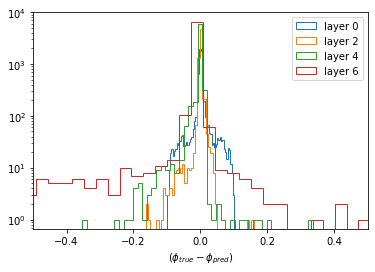

In [28]:
#phi_res = residuals(targets[:,0,0].cpu(), predictions[:,0,0].detach().cpu())
#phi_res = phi_res[np.where((phi_res < .1) & (phi_res > -.1))[0]]
for i in range(0,8,2):
    phi_res = residuals(targets[:,i,0], predictions[:,i,0])
    res=[]
    for phi in phi_res:
        if phi > np.pi: phi=2*np.pi-phi
        elif phi < -np.pi: phi = phi+2*np.pi
        res.append(phi)
    res = np.array(res)
    plt.hist(np.array(res), bins=50, histtype='step', label='layer {}'.format(i));
plt.xlim([-.5, .5])
plt.yscale('log')
plt.legend()
plt.xlabel(r'$(\phi_{true} - \phi_{pred})$')

Text(0.5, 0, '$(z_{true} - z_{pred})/\\sigma_{z}$')

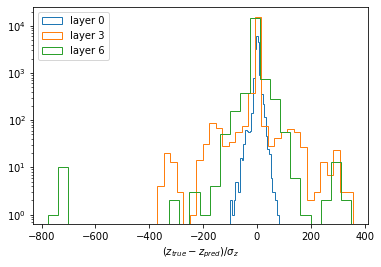

In [33]:
for i in range(0,8,3):
    z_res = residuals(targets[:,i,1], predictions[:,i,1])
    plt.hist(z_res, bins=30, histtype='step', label='layer {}'.format(i));
#plt.xlim([-.5, .5])
plt.yscale('log')
plt.legend()
plt.xlabel(r'$(z_{true} - z_{pred})/\sigma_{z}$')

In [24]:
test_target.shape

(16645, 9, 2)

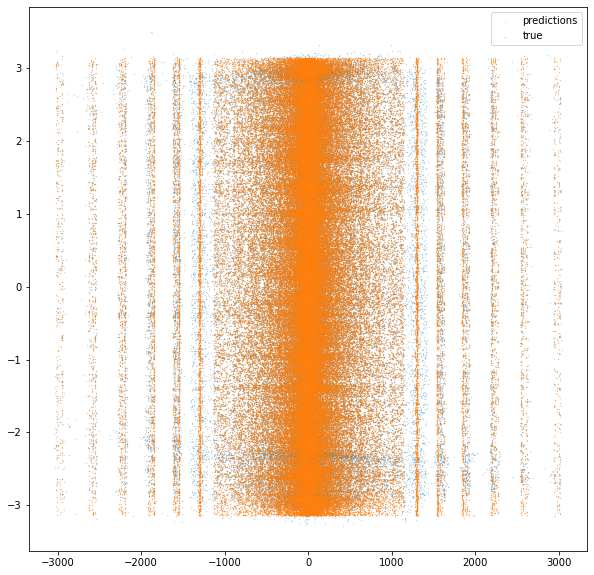

In [32]:
fig = plt.figure(figsize=(10,10))
plt.scatter(predictions[:,:,1], predictions[:,:,0], s=.05, alpha=.5,label='predictions')
plt.scatter(test_target[:,:,1]*zNorm, test_target[:,:,0]*phiNorm, s=.05, label='true')
plt.legend()


In [ ]:
inp = tf.Variable([[1,1],[2,2],[3,3]], dtype='float')
inp = tf.reshape(inp, (1,3,2,1))
targets = inp+.1
covs = tf.eye(2, batch_shape=[1,3],dtype='float')
outputs = (inp, covs)
#gaus_llh_loss(outputs,targets )

In [53]:
model = GaussianRNN(3)
inputs = tf.Variable([[1,1,1],[2,2,2],[3,3,3],[1,1,1],[2,2,2],[3,3,3]], dtype='float')
targets = inputs+0.1
outputs = tf.Variable([[1,1,5,1,1],[2,2,2,2,2],[3,3,3,3,3],[1,1,1,1,1],[2,2,2,2,2],[3,3,3,3,3]], dtype='float')
outputs = tf.reshape(outputs, (6,5))

In [54]:
mean = outputs[:,:2]
var = tf.math.exp(outputs[:,2:4])
var = tf.math.sqrt(var)
correlations = tf.math.tanh(outputs[:,4:])
shape = tf.shape(mean)

identity = tf.eye(2, batch_shape=[shape[0]],dtype=tf.float32)

correlations = tf.reshape(correlations, (6,1,1))
corr_matrix = tf.cast(tf.math.equal(identity,0),tf.float32) * correlations
corr_matrix = identity+corr_matrix

covs = tf.matmul(var[:, :,None], var[:, None, :])
covs = covs * corr_matrix
#outputs = self.concat([mean, covs]) 
mean = tf.reshape(mean, (, shape[1], 2))
covs = tf.reshape(covs, (shape[0], shape[1],2,2))

InvalidArgumentError: Input to reshape is a tensor with 12 values, but the requested shape has 24 [Op:Reshape]

In [167]:
means = outputs[0]
covs = outputs[1]
#print(len(outputs))
#print("mean shape: ", means.shape, " covs shape: ", covs.shape)
m_shape = means.shape
t_shape = targets.shape
means = tf.reshape(means, m_shape[0]*m_shape[1], m_shape[2])
targets = targets.reshape(targets,t_shape[0]*t_shape[1], t_shape[2] )
# Calculate the inverses of the covariance matrices
inv_covs = tf.linalg.inv(covs)
# Calculate the residual error
res = targets - means
res = tf.reshape(res, (shape[0], shape[1],2,1))
# Calculate the residual error term
res_right = tf.matmul(inv_covs, res)
res_term = tf.matmul(tf.transpose(res,perm=(0,1,3,2)), res_right)
diag_chols = tf.linalg.diag_part(tf.linalg.cholesky(covs))
log_det = tf.reduce_sum(diag_chols, axis=2)
log_det = tf.math.log(log_det)*2
gllh_loss = tf.reduce_sum(tf.reshape(res_term, (shape[0],shape[1])) + log_det, axis=-1)

InvalidArgumentError: Matrix size-incompatible: In[0]: [1,3,2,2], In[1]: [3,2] [Op:BatchMatMulV2]

In [168]:
res_right

<tf.Tensor: shape=(1, 3, 2, 1), dtype=float32, numpy=
array([[[[0.1049097 ],
         [0.09966367]],

        [[0.1132513 ],
         [0.10027757]],

        [[0.12170206],
         [0.10134877]]]], dtype=float32)>

In [ ]:
inv_covs

In [145]:
mean = tf.constant([[.1,10], [.6,20],[.3,30],[-.1,-15],[-.2,25],[-.3,3]], dtype='double')
mean = tf.reshape(mean, (2,3,2)) #batch size 2, 3 hits, 2 features
targets = mean+.1
var = mean / 2
correlations = tf.reshape(tf.constant([-.5,-5,-.2,-.3,-.1,-.9,], dtype='double'),(2,3,1,1))
identity = tf.eye(2, batch_shape=[2,3],dtype='double')
corr_matrix = tf.cast(tf.math.equal(identity,0), tf.float64) * correlations
corr_matrix = identity+corr_matrix
var = tf.math.exp(var)
var = tf.math.sqrt(var)
covs = tf.matmul(var[:, :,:,None], var[:,:, None, :])
covs_final = covs * corr_matrix


In [146]:
1.21824940e+01**2

148.413160060036

In [147]:
var

<tf.Tensor: shape=(2, 3, 2), dtype=float64, numpy=
array([[[1.02531512e+00, 1.21824940e+01],
        [1.16183424e+00, 1.48413159e+02],
        [1.07788415e+00, 1.80804241e+03]],

       [[9.75309912e-01, 2.35177459e-02],
        [9.51229425e-01, 5.18012825e+02],
        [9.27743486e-01, 2.11700002e+00]]])>

In [148]:
covs

<tf.Tensor: shape=(2, 3, 2, 2), dtype=float64, numpy=
array([[[[1.05127110e+00, 1.24908953e+01],
         [1.24908953e+01, 1.48413159e+02]],

        [[1.34985881e+00, 1.72431490e+02],
         [1.72431490e+02, 2.20264658e+04]],

        [[1.16183424e+00, 1.94886026e+03],
         [1.94886026e+03, 3.26901737e+06]]],


       [[[9.51229425e-01, 2.29370906e-02],
         [2.29370906e-02, 5.53084370e-04]],

        [[9.04837418e-01, 4.92749041e+02],
         [4.92749041e+02, 2.68337287e+05]],

        [[8.60707976e-01, 1.96403298e+00],
         [1.96403298e+00, 4.48168907e+00]]]])>

In [124]:
mean = tf.constant([[.1,10], [.2,20],[.3,30],[-.1,-15],[-.2,25],[-.3,3]], dtype='double')
mean = tf.reshape(mean, (6,2)) #batch size 2, 3 hits, 2 features
targets = mean+.1
var = mean / 2
correlations = tf.reshape(tf.constant([-.5,-.5,-.2,-.3,-.1,-.9,], dtype='double'),(6,1,1))
identity = tf.eye(2, batch_shape=[6],dtype='double')
corr_matrix = tf.cast(tf.math.equal(identity,0), tf.float64) * correlations
corr_matrix = identity+corr_matrix
var = tf.math.exp(var)
var = tf.math.sqrt(var)
covs = tf.matmul(var[:, :,None], var[:, None, :])
covs_final = covs * corr_matrix


In [129]:
var

<tf.Tensor: shape=(6, 2), dtype=float64, numpy=
array([[1.02531512e+00, 1.21824940e+01],
       [1.05127110e+00, 1.48413159e+02],
       [1.07788415e+00, 1.80804241e+03],
       [9.75309912e-01, 2.35177459e-02],
       [9.51229425e-01, 5.18012825e+02],
       [9.27743486e-01, 2.11700002e+00]])>

In [132]:
var

<tf.Tensor: shape=(6, 2), dtype=float64, numpy=
array([[1.02531512e+00, 1.21824940e+01],
       [1.05127110e+00, 1.48413159e+02],
       [1.07788415e+00, 1.80804241e+03],
       [9.75309912e-01, 2.35177459e-02],
       [9.51229425e-01, 5.18012825e+02],
       [9.27743486e-01, 2.11700002e+00]])>

In [131]:
tf.matmul(var[:,:,None], var[:,None,:])

<tf.Tensor: shape=(6, 2, 2), dtype=float64, numpy=
array([[[1.05127110e+00, 1.24908953e+01],
        [1.24908953e+01, 1.48413159e+02]],

       [[1.10517092e+00, 1.56022464e+02],
        [1.56022464e+02, 2.20264658e+04]],

       [[1.16183424e+00, 1.94886026e+03],
        [1.94886026e+03, 3.26901737e+06]],

       [[9.51229425e-01, 2.29370906e-02],
        [2.29370906e-02, 5.53084370e-04]],

       [[9.04837418e-01, 4.92749041e+02],
        [4.92749041e+02, 2.68337287e+05]],

       [[8.60707976e-01, 1.96403298e+00],
        [1.96403298e+00, 4.48168907e+00]]])>

In [135]:
1.02531512*1.21824940e01

12.49089529750928